In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation

from alr_sim.sims.SimFactory import SimRepository
from alr_sim.core import Scene
from alr_sim.sims import MjCamera
from alr_sim.sims.universal_sim.PrimitiveObjects import Box
from alr_sim.sims.mj_beta.mj_utils.mj_render_singleton import reset_singleton

from alr_simulation_tools.scene_utils import execute_grasping_sequence

pybullet build time: Oct 28 2022 16:11:27


In [2]:
### CONVENTION FOR THIS NOTEBOOK: Quaterniions are represented as [w, x, y, z] ###

In [3]:
cam_pos_init = np.array([0.5, 0.3, 1.0])
cam_euler_init = np.array([0.0, 0.0, -90])
cam_rot_init = Rotation.from_euler("xyz", cam_euler_init, degrees=True).as_matrix()
cam_quat_init = Rotation.from_euler("xyz", cam_euler_init, degrees=True).as_quat()[
    [3, 0, 1, 2]
]

box_size = 0.02
box_positions_world_init = np.array(
    [
        (x, y, 0)
        for x in [0.3, 0.4, 0.5, 0.6]
        for y in [0.7, 0.5, 0.3, 0.1, -0.1]
    ]
)

# drop pos cannot be outside of field due to robot constraints
home_pos = np.array((0.5, 0.0, 0.3))
drop_pos = np.array((0.3 , -0.3, 0.5))
initial_pos = np.array((0.0, 0.5, 0.05))
grasp_quat = np.array((0, 1, 0, 0))

move_time = 4
wait_time = 1
grasp_move_time = 2

In [4]:
object_list = [
    Box(
        name=f"box_{c[0]}_{c[1]}_{c[2]}",
        init_pos=c,
        init_quat=[0, 1, 0, 0],
        rgba=[1, 0, 0, 1],
        size=[box_size, box_size, box_size],
    )
    for c in box_positions_world_init
]

In [5]:
sim_factory = SimRepository.get_factory("mj_beta")
scene = sim_factory.create_scene(
    object_list=object_list, dt=0.0003, render=Scene.RenderMode.HUMAN
)
agent = sim_factory.create_robot(scene, dt=0.0003)

cam = MjCamera("my_cam", init_pos=cam_pos_init, init_quat=cam_quat_init)
scene.add_object(cam)
cam.set_cam_params(height=480, width=640)

scene.start()

agent.gotoCartPositionAndQuat(initial_pos, grasp_quat, duration=move_time)

rgb_img, depth_img = cam.get_image()

cam_intrinsics = cam.intrinsics
cam_pos, cam_quat_ = cam.get_cart_pos_quat()
cam_rot = Rotation.from_quat(cam_quat_[[1, 2, 3, 0]]).as_matrix()
seg_img = cam.get_segmentation(depth=False)
box_obj_ids = [
    scene.get_obj_seg_id(obj_name=f"box_{c[0]}_{c[1]}_{c[2]}")
    for c in box_positions_world_init
]

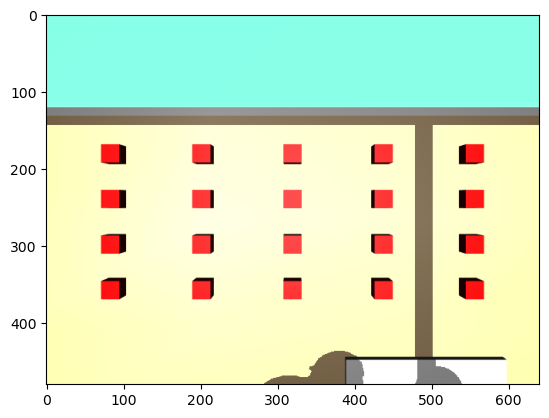

In [ ]:
plt.imshow(rgb_img)

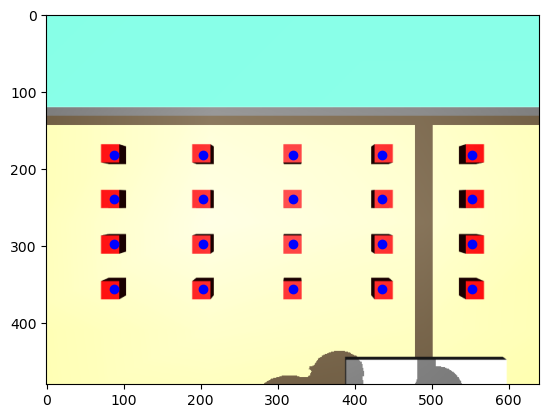

In [ ]:
ps_img = []

for seg_id in box_obj_ids:
    p_img = np.mean(np.where(seg_img == seg_id), axis=-1)
    ps_img.append((p_img[1], p_img[0])) # !!!!
ps_img = np.array(ps_img)

plt.imshow(rgb_img)
plt.scatter(ps_img[:,0], ps_img[:,1], c="b")

In [ ]:
cx = cam_intrinsics[0, 2]
cy = cam_intrinsics[1, 2]
fx = cam_intrinsics[0, 0]
fy = cam_intrinsics[1, 1]

ps_cam = []

for p_img in ps_img:
    p_cz = depth_img[int(p_img[1]), int(p_img[0])]

    p_cam_x = (p_img[0] - cx) * p_cz / fx
    p_cam_y = (p_img[1] - cy) * p_cz / fy
    p_cam = [p_cam_x, p_cam_y, p_cz]
    ps_cam.append(p_cam)

ps_cam = np.array(ps_cam)

print(ps_cam)

[[-4.06691648e-01  1.95240820e-01  9.79033768e-01]
 [-2.03375887e-01  1.95169732e-01  9.79033768e-01]
 [-8.72818557e-04  1.95292396e-01  9.79033768e-01]
 [ 2.01630250e-01  1.95169732e-01  9.79033768e-01]
 [ 4.04946011e-01  1.95240820e-01  9.79033768e-01]
 [-4.06691434e-01  9.72362886e-02  9.79033768e-01]
 [-2.03376503e-01  9.71627382e-02  9.79033768e-01]
 [-8.72818557e-04  9.72259193e-02  9.79033768e-01]
 [ 2.01630866e-01  9.71627382e-02  9.79033768e-01]
 [ 4.04945797e-01  9.72362886e-02  9.79033768e-01]
 [-4.06933330e-01 -8.44852218e-04  9.79033768e-01]
 [-2.03502612e-01 -8.44852218e-04  9.79033768e-01]
 [-8.72818557e-04 -8.44852218e-04  9.79033768e-01]
 [ 2.01756975e-01 -8.44852218e-04  9.79033768e-01]
 [ 4.05187692e-01 -8.44852218e-04  9.79033768e-01]
 [-4.06691434e-01 -9.89259931e-02  9.79033768e-01]
 [-2.03376503e-01 -9.88524426e-02  9.79033768e-01]
 [-8.72818557e-04 -9.89156237e-02  9.79033768e-01]
 [ 2.01630866e-01 -9.88524426e-02  9.79033768e-01]
 [ 4.04945797e-01 -9.89259931e-

In [ ]:
ps_world = []

for p_cam in ps_cam:
    p_world = np.linalg.inv(cam_rot) @ p_cam + cam_pos
    p_world[2] -= 0.01
    ps_world.append(p_world)

ps_world = np.array(ps_world)

print(ps_world)

[[ 0.30475918  0.70669165  0.01096623]
 [ 0.30483027  0.50337589  0.01096623]
 [ 0.3047076   0.30087282  0.01096623]
 [ 0.30483027  0.09836975  0.01096623]
 [ 0.30475918 -0.10494601  0.01096623]
 [ 0.40276371  0.70669143  0.01096623]
 [ 0.40283726  0.5033765   0.01096623]
 [ 0.40277408  0.30087282  0.01096623]
 [ 0.40283726  0.09836913  0.01096623]
 [ 0.40276371 -0.1049458   0.01096623]
 [ 0.50084485  0.70693333  0.01096623]
 [ 0.50084485  0.50350261  0.01096623]
 [ 0.50084485  0.30087282  0.01096623]
 [ 0.50084485  0.09824303  0.01096623]
 [ 0.50084485 -0.10518769  0.01096623]
 [ 0.59892599  0.70669143  0.01096623]
 [ 0.59885244  0.5033765   0.01096623]
 [ 0.59891562  0.30087282  0.01096623]
 [ 0.59885244  0.09836913  0.01096623]
 [ 0.59892599 -0.1049458   0.01096623]]


In [ ]:
for i in range(len(ps_world)):
    print(f"delta_x: {round(ps_world[i,0] - box_positions_world_init[i,0],3)}, delta_y: {round(ps_world[i,1] - box_positions_world_init[i,1],3)}")

delta_x: 0.005, delta_y: 0.007
delta_x: 0.005, delta_y: 0.003
delta_x: 0.005, delta_y: 0.001
delta_x: 0.005, delta_y: -0.002
delta_x: 0.005, delta_y: -0.005
delta_x: 0.003, delta_y: 0.007
delta_x: 0.003, delta_y: 0.003
delta_x: 0.003, delta_y: 0.001
delta_x: 0.003, delta_y: -0.002
delta_x: 0.003, delta_y: -0.005
delta_x: 0.001, delta_y: 0.007
delta_x: 0.001, delta_y: 0.004
delta_x: 0.001, delta_y: 0.001
delta_x: 0.001, delta_y: -0.002
delta_x: 0.001, delta_y: -0.005
delta_x: -0.001, delta_y: 0.007
delta_x: -0.001, delta_y: 0.003
delta_x: -0.001, delta_y: 0.001
delta_x: -0.001, delta_y: -0.002
delta_x: -0.001, delta_y: -0.005


In [ ]:
agent.gotoCartPositionAndQuat(home_pos, grasp_quat, duration=move_time)
agent.wait(wait_time)

for p_world in ps_world:
    print(f"Executing grasp at {p_world}")
    execute_grasping_sequence(
        agent,
        home_pos,
        p_world,
        drop_pos,
        grasp_quat,
        hover_offset=(0,0,0.05),
        movement_time=move_time,
        grasp_movement_time=grasp_move_time,
        wait_time=wait_time,
        logging=True,
    )    

SyntaxError: invalid syntax. Perhaps you forgot a comma? (378460474.py, line 10)